# Directer Graphs - Topological Sorting

---

*Give me an order of the nodes in a directed (acyclic) graph so that every edge goes from left to right in that order, i.e $u$ must be done before $v$.*

More formally: A linear ordering of vertices such that every edge $u \to v$ has $u$ before $v$ in the order.

## Properties

* It only exists if there are no directed cycles (if there is a cycle, the constraints contradict each other).
* The order is not necessarily unique; many valid topological orders can exist for the same DAG.

## Implementation

In [1]:
from collections import deque
from typing import Any, List

from importnb import Notebook

from theoria.validor import TestCase, Validor

with Notebook():
    from notebooks.computer_science.data_structures.graphs.__basic__directed_graph import (
        AdjacencyListDirectedGraph,
        GraphNode,
    )

import logging

In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler())

## Post-Order DFS

In [3]:
def dfs_topological_sort(graph: AdjacencyListDirectedGraph) -> List[GraphNode]:
    # Go to the deepest node first, then backtrack
    # Reverse the final order to get the correct dependency order
    # Post-order (add to order after visiting all neighbors)
    order: List[GraphNode] = []
    visited: set[GraphNode] = set()
    rec_stack: set[GraphNode] = set()

    def dfs(u: GraphNode) -> None:
        if u in rec_stack:
            raise ValueError("Cycle detected; topological order undefined")
        if u in visited:
            return

        rec_stack.add(u)
        for v in graph.adjacency_list.get(u, []):
            dfs(v)
        rec_stack.remove(u)

        visited.add(u)
        order.append(u)

    for node in graph.adjacency_list.keys():
        if node not in visited:
            dfs(node)

    order.reverse()
    return order

## Kahn's Algorithm (BFS-like)

In [4]:
def kahn_topological_sort(graph: AdjacencyListDirectedGraph) -> List[GraphNode]:
    # Compute in-degree of every node
    indeg: dict["GraphNode", int] = {u: 0 for u in graph.adjacency_list}

    # Include nodes that only appear as targets
    for _u, nbrs in graph.adjacency_list.items():
        for v in nbrs:
            if v not in indeg:
                indeg[v] = 0
            indeg[v] += 1

    # Queue of all nodes with in-degree 0
    q = deque(node for node, d in indeg.items() if d == 0)
    order: list["GraphNode"] = []

    # Process queue (BFS)
    while q:
        u = q.popleft()
        order.append(u)

        for v in graph.adjacency_list.get(u, []):
            indeg[v] -= 1
            if indeg[v] == 0:
                q.append(v)

    # Detect cycle
    if len(order) != len(indeg):
        raise ValueError("Graph has a cycle; no topological ordering exists")

    return order

# Tests

In [5]:
def build_toposort_test(
    graph: AdjacencyListDirectedGraph,
    expected_order: List[Any],
    description: str,
) -> TestCase:
    return TestCase(
        input_data={"graph": graph},
        expected_output=expected_order,
        description=description,
    )

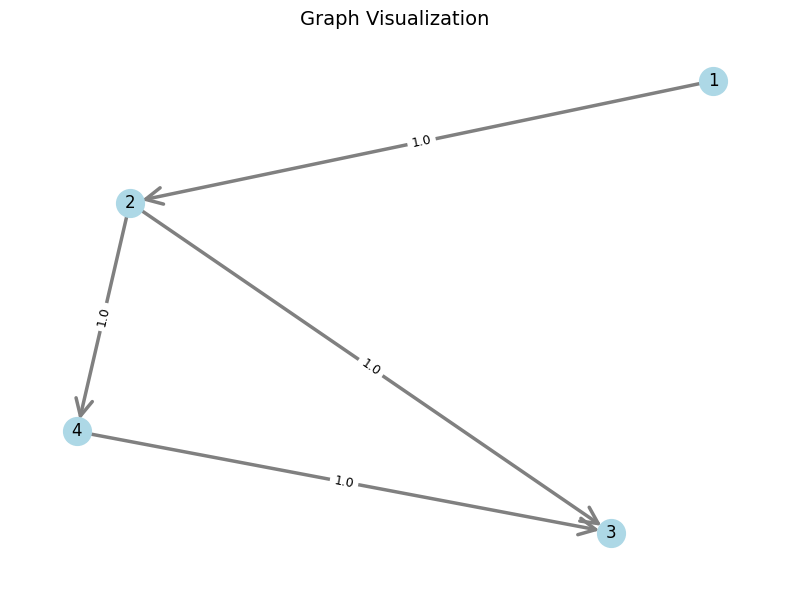

[2026-01-09 20:40:13,460] [INFO] All 1 tests passed for dfs_topological_sort.


[2026-01-09 20:40:13,460] [INFO] All 1 tests passed for kahn_topological_sort.


In [6]:
graph_1 = AdjacencyListDirectedGraph(
    {
        GraphNode(1): {GraphNode(2): 1.0},
        GraphNode(2): {GraphNode(3): 1.0, GraphNode(4): 1.0},
        GraphNode(3): {},
        GraphNode(4): {GraphNode(3): 1.0},
    }
)

if __name__ == "__main__":
    graph_1.visualise()

    # DFS
    Validor(dfs_topological_sort).add_case(
        build_toposort_test(
            graph_1,
            [GraphNode(1), GraphNode(2), GraphNode(4), GraphNode(3)],
            "Simple DAG topological sort using DFS",
        )
    ).run()

    # Kahn's
    Validor(kahn_topological_sort).add_case(
        build_toposort_test(
            graph_1,
            [GraphNode(1), GraphNode(2), GraphNode(4), GraphNode(3)],
            "Simple DAG topological sort using Kahn's Algorithm",
        )
    ).run()

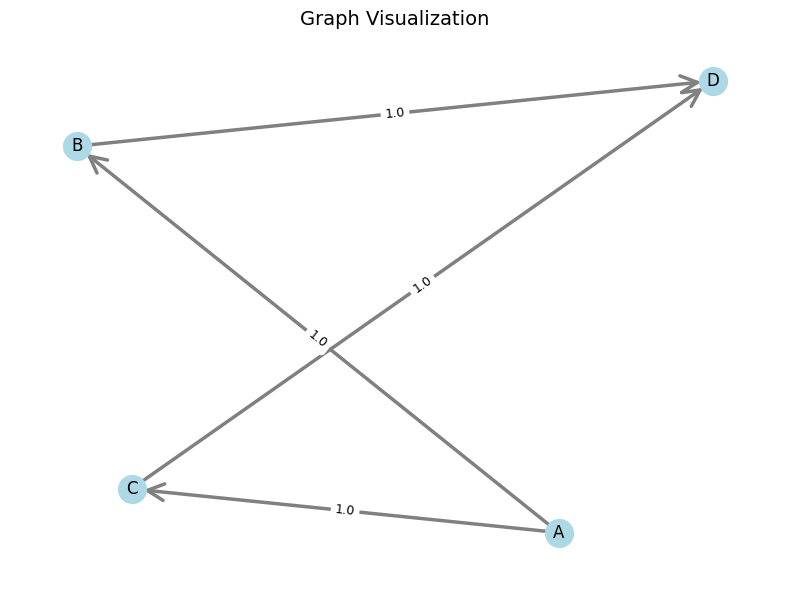

[2026-01-09 20:40:13,576] [INFO] All 1 tests passed for dfs_topological_sort.


[2026-01-09 20:40:13,576] [INFO] All 1 tests passed for kahn_topological_sort.


In [7]:
graph_2 = AdjacencyListDirectedGraph(
    {
        GraphNode("A"): {GraphNode("B"): 1.0, GraphNode("C"): 1.0},
        GraphNode("B"): {GraphNode("D"): 1.0},
        GraphNode("C"): {GraphNode("D"): 1.0},
        GraphNode("D"): {},
    }
)

if __name__ == "__main__":
    graph_2.visualise()

    # DFS
    Validor(dfs_topological_sort).add_case(
        build_toposort_test(
            graph_2,
            [GraphNode("A"), GraphNode("C"), GraphNode("B"), GraphNode("D")],
            "Simple DAG topological sort using DFS with string nodes",
        )
    ).run()

    # Kahn's
    Validor(kahn_topological_sort).add_case(
        build_toposort_test(
            graph_2,
            [GraphNode("A"), GraphNode("B"), GraphNode("C"), GraphNode("D")],
            "Simple DAG topological sort using Kahn's Algorithm with string nodes",
        )
    ).run()

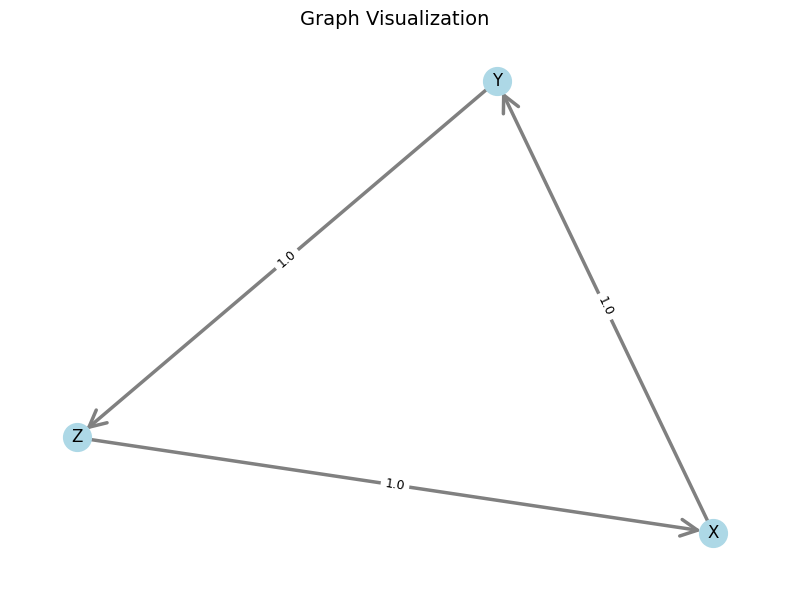

Caught expected error in DFS topological sort for cyclic graph


Caught expected error in Kahn's topological sort for cyclic graph


In [8]:
graph_3 = AdjacencyListDirectedGraph(
    {
        GraphNode("X"): {GraphNode("Y"): 1.0},
        GraphNode("Y"): {GraphNode("Z"): 1.0},
        GraphNode("Z"): {GraphNode("X"): 1.0},  # This creates a cycle
    }
)

if __name__ == "__main__":
    graph_3.visualise()

    try:
        # DFS
        Validor(dfs_topological_sort).add_case(
            build_toposort_test(
                graph_3,
                [],
                "Cyclic graph should raise error in DFS topological sort",
            )
        ).run()
    except AssertionError:
        log.info("Caught expected error in DFS topological sort for cyclic graph")

    # Kahn's
    try:
        Validor(kahn_topological_sort).add_case(
            build_toposort_test(
                graph_3,
                [],
                "Cyclic graph should raise error in Kahn's topological sort",
            )
        ).run()
    except AssertionError:
        log.info("Caught expected error in Kahn's topological sort for cyclic graph")

## Complexity

* Time Complexity: $O(V + E)$ for both
* Space Complexity: $O(V)$ for both